In [3]:
using Pkg; Pkg.activate("C:\\Users\\KarlH\\Desktop\\ComputationalPhysicsMaster\\Code\\OrbitalNeuralMethods")
using Revise
using OrbitalNeuralMethods

  Activating project at `C:\Users\KarlH\Desktop\ComputationalPhysicsMaster\Code\OrbitalNeuralMethods`
┌ Info: Precompiling OrbitalNeuralMethods [6de8678a-dd1c-461e-a987-24da1d9562b4]
└ @ Base loading.jl:1662


In [4]:
import Random
rng = Random.MersenneTwister();

In [46]:
n = 2
ω = 0.25
ham = HOCoulomb(ω, shielding = 0.25);

l = 10
basis = SpinBasis(HOBasis(l, ω))
grid = [x for x in range(-10, stop = 10, length = 2001)]
system = System(n, basis, grid, ham);

mixer = Alpha(0.5)
rhf = RHF(system, mixer);
rhf = compute_ground_state!(rhf, max_iter = 100, tol = 1e-10, verbose=0);
energy(rhf)

1.17957942722023

In [6]:
slater = Slater(rhf);

In [144]:
function energy_opt(wf, optimizer)
    ham = HOCoulomb(0.25, shielding = 0.25);

    metro = Importance(equils = 1e4, samples = 1e5, step = 0.01);
    t = @elapsed wf, grad_results = optimize(wf, ham, metro, optimizer, nthreads = 12, verbose = true);
    println("\nGradient time: $(t) s")
    return wf
end

function energy_block(wf)
    samples_b = 2^25
    metro_b = Importance(equils = 1e6, samples = samples_b, step = 0.01);
    t = @elapsed result = blocking(wf, ham, metro_b, nthreads = 12);
    digits = Integer(-floor(log10(result.E_err)))
    print("$(round(result.E, digits=digits)) ± $(round(result.E_err, digits=digits)), $(round(result.E - 0.8247, digits=digits))")
    println("\nBlocking time: $(t) s")
end

energy_block (generic function with 1 method)

### 8

In [97]:
nn = NeuralNetwork([Dense(8), Tanh, Dense(1), Exp], n=n, rng = rng);
wf = SlaterNN(slater, nn);
optimizer = ADAM(wf, lr = 0.01, max_iter = 200, tol = 1e-6);
wf8 = energy_opt(wf, optimizer);
energy_block(wf8);

E = 0.836094 iter = 200/200                                      
Gradient time: 14.5112415 s
0.8322 ± 0.0006, 0.0075
Blocking time: 15.6885065 s


### 16

In [14]:
nn = NeuralNetwork([Dense(16), Tanh, Dense(1), Exp], n=n, rng = rng);
wf = SlaterNN(slater, nn);
optimizer = ADAM(wf, lr = 0.01, max_iter = 200, tol = 1e-6);
wf16 = energy_opt(wf, optimizer);
energy_block(wf16);

E = 0.842908 iter = 200/200                                      
Gradient time: 17.6864257 s
0.827 ± 0.0004, 0.0023
Blocking time: 18.6116485 s


### 32

In [121]:
nn = NeuralNetwork([Dense(32), Tanh, Dense(1), Exp], n=n, rng = rng);
wf = SlaterNN(slater, nn);
optimizer = ADAM(wf, lr = 0.01, max_iter = 200, tol = 1e-6);
wf32 = energy_opt(wf, optimizer);
energy_block(wf32);

E = 0.82913 iter = 200/200                                       
Gradient time: 21.5764862 s
0.8252 ± 0.0004, 0.0005
Blocking time: 22.141302 s


In [160]:
2^27 - 1.34217728*10^8

0.0

┌ Error: Error watching manifest
│   exception = (Revise.ReviseEvalException("C:\\Users\\KarlH\\.julia\\packages\\JLLWrappers\\QpMQW\\src\\toplevel_generators.jl:156", MethodError(Glib_jll.var"#make_wrapper_dict#10"{Glib_jll.var"#parse_wrapper_platform#9"}(Glib_jll.var"#parse_wrapper_platform#9"()), ("C:\\Users\\KarlH\\.julia\\packages\\Glib_jll\\QfIde\\src", ["aarch64-apple-darwin.jl", "aarch64-linux-gnu.jl", "aarch64-linux-musl.jl", "armv6l-linux-gnueabihf.jl", "armv6l-linux-musleabihf.jl", "armv7l-linux-gnueabihf.jl", "armv7l-linux-musleabihf.jl", "i686-linux-gnu.jl", "i686-linux-musl.jl", "i686-w64-mingw32.jl", "powerpc64le-linux-gnu.jl", "x86_64-apple-darwin.jl", "x86_64-linux-gnu.jl", "x86_64-linux-musl.jl", "x86_64-unknown-freebsd.jl", "x86_64-w64-mingw32.jl"]), 0x0000000000007ecf), Any[(top-level scope at toplevel_generators.jl:156, 1)]), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x0000000001261b99])
└ @ Revise C:\Users\KarlH\.julia\packages\Revise\do2nH\src\pkgs.jl

In [132]:
2^27

134217728

In [133]:
samples_b = 2^27
metro_b = Importance(equils = 1e6, samples = samples_b, step = 0.01);
@time result = blocking(wf32, ham, metro_b, nthreads = 12);

 86.272091 seconds (2.38 k allocations: 11.001 GiB, 7.98% gc time)


In [134]:
digits = Integer(-floor(log10(result.E_err)))
print("$(round(result.E, digits=digits)) ± $(round(result.E_err, digits=digits)), $(round(result.E - 0.8247, digits=digits))")

0.8257 ± 0.0002, 0.001

In [158]:
round((0.82488 - 0.8247) / 0.8247, digits=4)

0.0002

### Density

In [62]:
hf = HF(system)
hf = compute_ground_state!(hf, max_iter = 1000, tol = 1e-10, verbose=0);
hf_dens = particle_density(System(hf));

In [20]:
import Plots as plt
plt.pyplot()

Plots.PyPlotBackend()

In [74]:
hf = HF(system);
compute_ground_state!(hf, max_iter = 1000, tol = 1e-10);
hf_density = particle_density(System(hf));
rhf_density  = particle_density(System(rhf));

In [78]:
include("Figures/imgplot.jl");

In [123]:
metro = Importance(equils = 1e5, samples = 1e8, step = 0.01);
ob_result = onebody(wf32, ham, metro, start = -10, stop = 10, length = 200, nthreads = 12);
(; radius, oneBodyDensity) = ob_result;

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


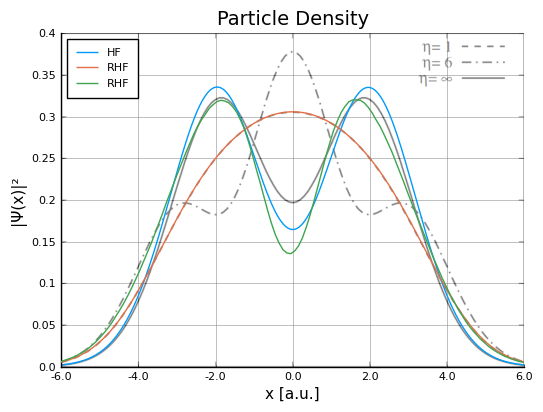

In [124]:
x_trans, y_trans = imgplot(file     = "Figures/GS.PNG",
                           extent   = [-6, 6, 0, 0.4],
                           imgalpha = 0.5,
                           yticks   = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
                           xticks   = [x for x in -6:2:6],
                           )

plt.plot!(legend=:topleft, title="Particle Density", xlabel="x [a.u.]", ylabel="|Ψ(x)|²")
plt.plot!(x_trans.(grid), y_trans.(hf_density), label="HF", lw=1, c=1)
plt.plot!(x_trans.(grid), y_trans.(rhf_density), label="RHF", lw=1, c=2)
plt.plot!(x_trans.(radius), y_trans.(oneBodyDensity.*2), label="RHF", lw=1, c=3)
plt.savefig("Figures/particle_dens_zang.png")
plt.plot!()
plt.show();

In [ ]:
E = 0.824306 iter = 100/100                                      
Gradient time: 11.2272677 s
0.8255 ± 0.0007, 0.0008
Blocking time: 22.7916894 s